## A neural networks classifier model to determine customer churn

Customer churn is an important consideration for banks as it hurts their business. If banks can learn in advance that a customer might leave, they can try to incentivize them to stay. In this project a neural network is developed that predicts if a customer will churn. The dataset provided for training has existing customers details, their bank service usage and whether they were a churn or not. 

In [208]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

### Load customer churn data

In [75]:
df = pd.read_csv("Churn.csv")

### Data overview

In [18]:
df.shape

(10000, 14)

Data has 10000 rows and 14 columns. Printing sample 10 rows of data.

In [19]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


### Summary

Concise summary

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [29]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Remove features that would have no bearing on the target

In [76]:
df.drop(labels=['RowNumber','CustomerId','Surname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Detailed summary of the numeric features

In [15]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Data preparation

Check for missing data

In [22]:
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing data. Convert non numeric fields to categorical.

In [25]:
categoryCols = ['Geography','Gender']
for cat in categoryCols:
    df[cat] = df[cat].astype('category')

### Univariate Analysis

In [33]:
for cat in categoryCols:
    print(df[cat].value_counts())
    print()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Male      5457
Female    4543
Name: Gender, dtype: int64



array([[<AxesSubplot:title={'center':'CreditScore'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Tenure'}>],
       [<AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'NumOfProducts'}>,
        <AxesSubplot:title={'center':'HasCrCard'}>],
       [<AxesSubplot:title={'center':'IsActiveMember'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>,
        <AxesSubplot:title={'center':'Exited'}>]], dtype=object)

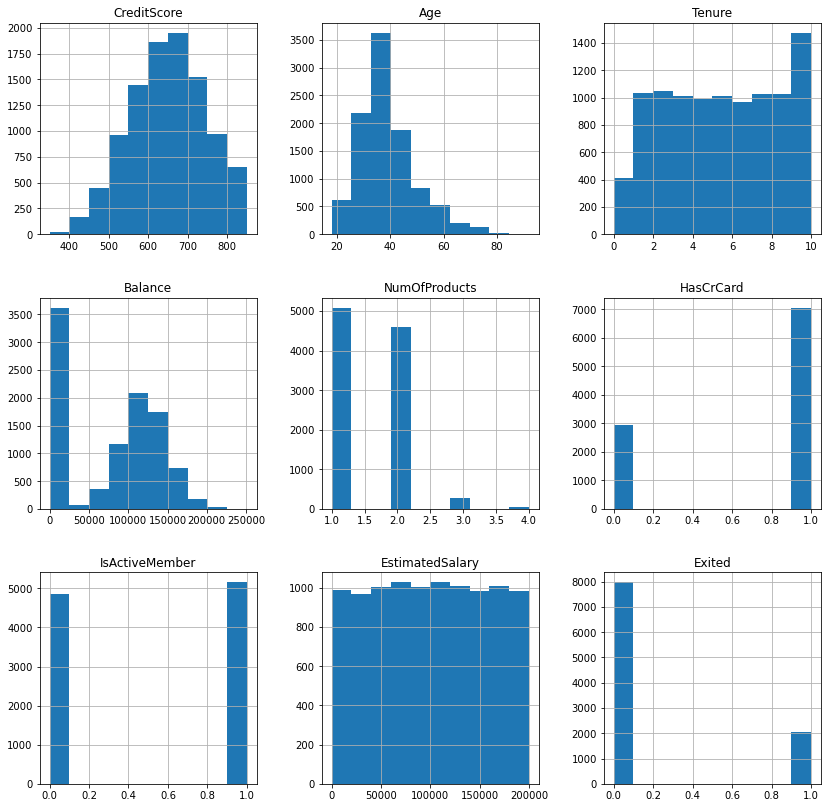

In [34]:
df.hist(figsize=(14,14))

* Geography: The customers are from three different countries.
* Gender: Both male and female customers are included.
* CreditScore: The credit score ranges from around 400 to 800 with mean in 600 to 700 range.
* Age: The distribution is right skewed with age range from around 20 to 80 with maximum number of customers in the age range of 35 and 40.
* Tenure: The number of years the customers have been with the bank is almost uniformly distributed for 1 to 9 years. The maximum number of customers are in the 9 - 10 years range.
* Balance: It is a combination of two distributions. There is a normal distribution from around 50000 to 200000. There is a bucket of customers from 0 to 25000 and this is the biggest bucket. This needs to be checked further.
* NumOfProducts: There are 4 products the bank offers and most customers have subscribed to 1 product and very few to all 4 products.
* HasCrCard: More than two thirds of the customers have a credit card.
* IsActiveMember: Almost half the customers are regularly active.
* Exited: The target variable, the churn, about 20% of the customers have the left bank. This is a lot of customers.


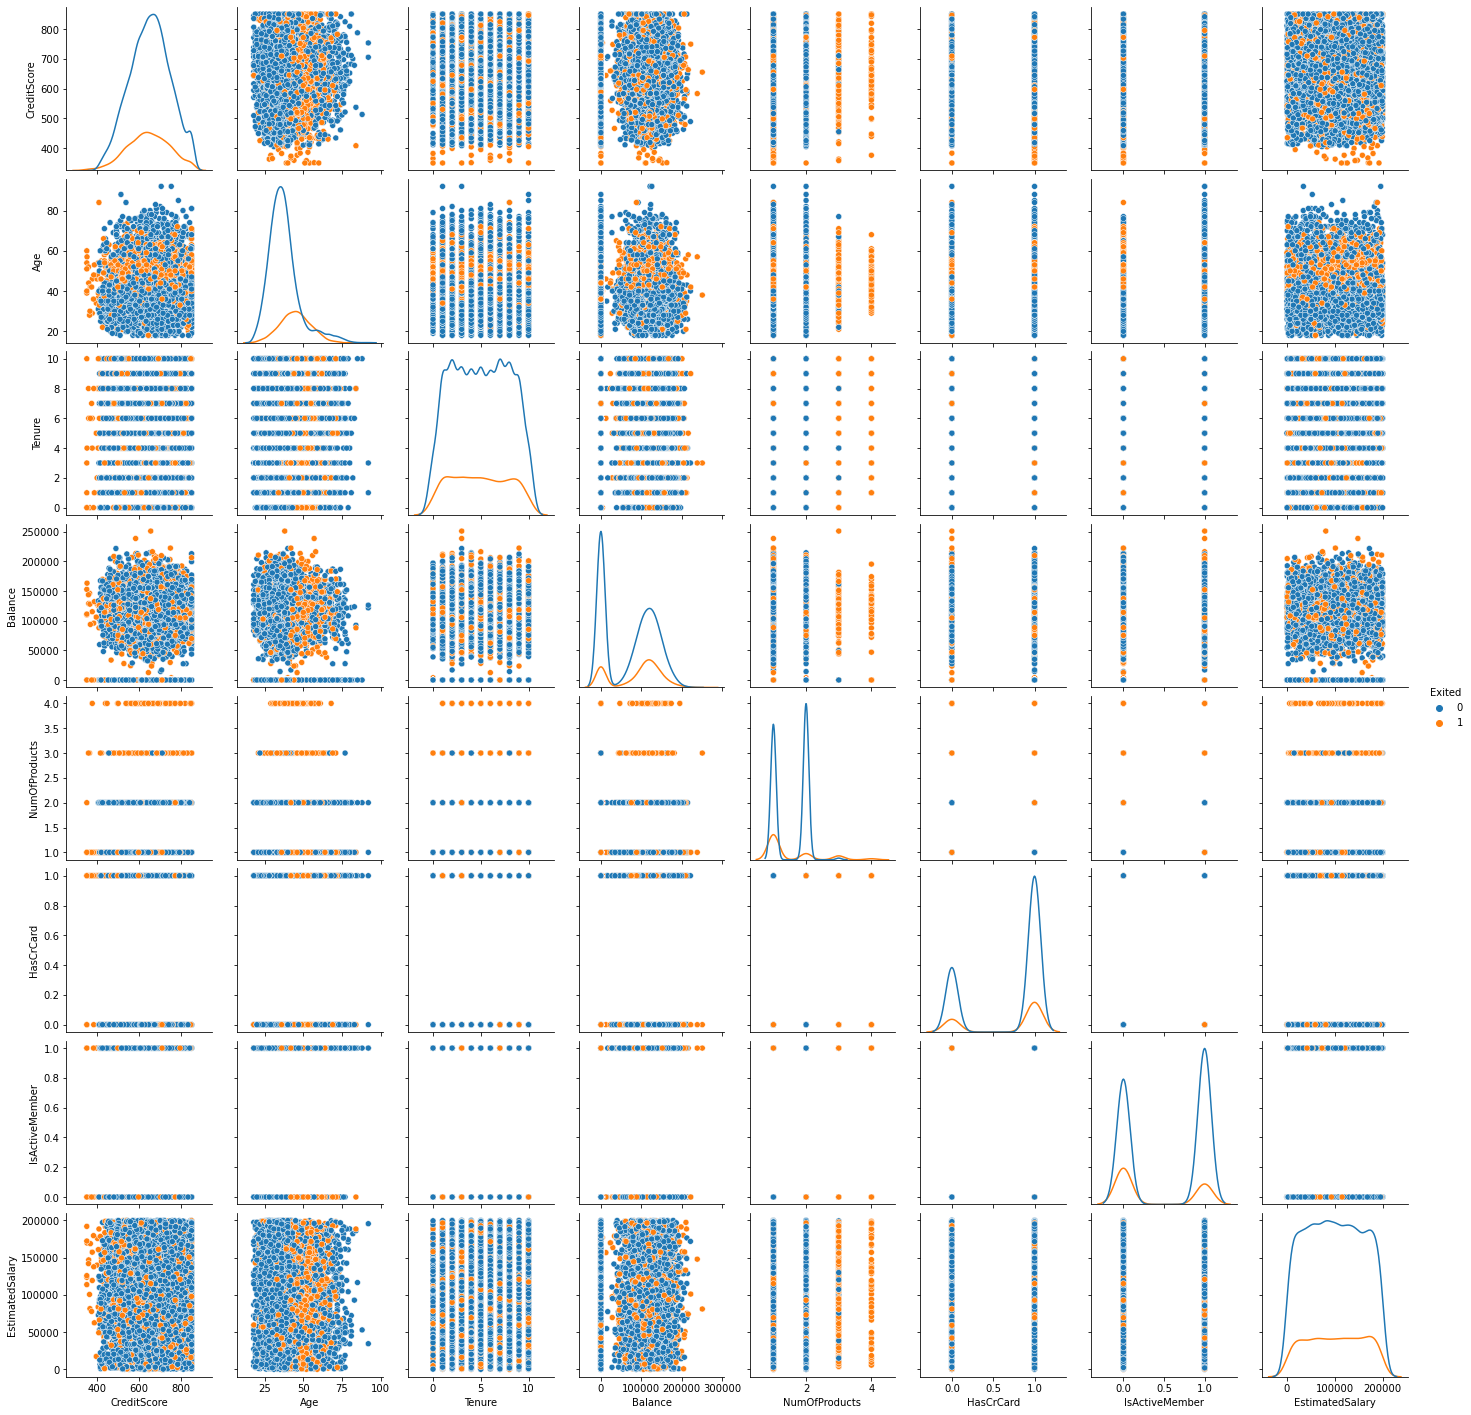

In [35]:
sns.pairplot(df, hue='Exited', diag_kind = "kde", diag_kws=dict(fill=False))
plt.show()

* All the features seem independent and no linear or polynomial relation between them
* Most of the customers who exited seem to be in the 50 age range
* If customers are subscribed to more than two products, they are likely to quit. This is worrisome as there would also be a higher loss of revenue from the multiple products.
* There are a number of customers who balance is 0. The 0 values seem to be across the whole tenure range. So it doesn't seem like a legitimate 0 balance scenario, when for example an account is opened. These are likely missing values that would need to be imputed.
* Tenure and EstimatedSalary are uniform distributions for both positve and negative classes.


### Data pre-processing

Split into train and test data

In [77]:
X = df.drop(columns='Exited')
y = df['Exited']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=Y)

Imputing missing Balance values to the mean value

In [93]:
#mean = df[df['Balance'] != 0]['Balance'].mean()
#print(mean)
#df.loc[df['Balance'] == 0, 'Balance'] = mean

imputer = SimpleImputer(missing_values=0, strategy='mean')

#Fit and transform the train data
X_train[['Balance']] = imputer.fit_transform(X_train[['Balance']])

#Transform the test data i.e. replace missing values with the mean calculated using training data
X_test[['Balance']] = imputer.transform(X_test[['Balance']])

Create one-hot encoded columns for the categorical columns

In [94]:
X_train=pd.get_dummies(X_train, columns=['Geography'])
X_train=pd.get_dummies(X_train, columns=['Gender'], drop_first=True)
X_test=pd.get_dummies(X_test, columns=['Geography'])
X_test=pd.get_dummies(X_test, columns=['Gender'], drop_first=True)

Scaling numeric columns

In [97]:
scaleCols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
X_train[scaleCols] = scaler.fit_transform(X_train[scaleCols])
X_test[scaleCols] = scaler.transform(X_test[scaleCols])

In [100]:
X_train.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7635,-1.385480,-0.938920,-1.035870,-6.131953e-01,-0.918448,1,0,1.012113,1,0,0,0
5284,0.979538,1.142223,-0.689110,-8.512947e-01,-0.918448,1,1,-1.235424,0,1,0,1
1457,2.063934,2.561184,-0.342351,-5.975166e-16,0.788704,0,1,-0.615548,1,0,0,1
4785,-1.447445,-1.601102,-0.689110,1.515892e+00,-0.918448,0,0,-0.965064,1,0,0,0
9158,-1.137618,-0.749725,1.738206,-7.216824e-02,-0.918448,1,1,1.023469,0,0,1,0
9891,0.308245,0.953028,1.738206,-5.975166e-16,0.788704,1,0,1.530533,1,0,0,1
3257,0.587089,1.804405,-0.689110,-7.214203e-01,-0.918448,1,1,0.264909,1,0,0,0
1395,0.566434,0.669236,0.697928,-5.975166e-16,0.788704,1,0,0.310412,0,0,1,1
8038,-0.383704,1.047626,0.004409,-7.667468e-01,0.788704,1,0,-1.522868,0,1,0,0
2867,-0.941394,-1.128115,-1.382629,-5.975166e-16,-0.918448,0,1,-1.723085,0,0,1,0


In [102]:
num_classes = 2
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [194]:
print(y_train.iloc[0])
print(y_train_cat[0])

0
[1. 0.]


### Model Building

In [104]:
print(X_train.shape)
print(y_test.shape)

(7000, 12)
(3000,)


In [236]:
model = Sequential()

model.add(Dense(64, activation='relu',kernel_initializer='he_uniform',input_shape=(12,))) ###Multiple Dense units with Relu activation
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

model.add(Dense(num_classes, activation='softmax'))

In [237]:
adam = optimizers.Adam(lr=1e-3)
model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

In [238]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 64)                832       
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,978
Trainable params: 2,978
Non-trainable params: 0
_________________________________________________________________


In [239]:
history = model.fit(X_train, y_train_cat, validation_split=0.2, epochs=20, batch_size=128, verbose=2)

Epoch 1/20
44/44 - 1s - loss: 0.5707 - accuracy: 0.7305 - val_loss: 0.5064 - val_accuracy: 0.7764 - 824ms/epoch - 19ms/step
Epoch 2/20
44/44 - 0s - loss: 0.4463 - accuracy: 0.7952 - val_loss: 0.4619 - val_accuracy: 0.7829 - 90ms/epoch - 2ms/step
Epoch 3/20
44/44 - 0s - loss: 0.4094 - accuracy: 0.8143 - val_loss: 0.4306 - val_accuracy: 0.8114 - 90ms/epoch - 2ms/step
Epoch 4/20
44/44 - 0s - loss: 0.3859 - accuracy: 0.8305 - val_loss: 0.4086 - val_accuracy: 0.8264 - 87ms/epoch - 2ms/step
Epoch 5/20
44/44 - 0s - loss: 0.3715 - accuracy: 0.8448 - val_loss: 0.3930 - val_accuracy: 0.8343 - 88ms/epoch - 2ms/step
Epoch 6/20
44/44 - 0s - loss: 0.3615 - accuracy: 0.8511 - val_loss: 0.3864 - val_accuracy: 0.8379 - 89ms/epoch - 2ms/step
Epoch 7/20
44/44 - 0s - loss: 0.3546 - accuracy: 0.8552 - val_loss: 0.3869 - val_accuracy: 0.8379 - 88ms/epoch - 2ms/step
Epoch 8/20
44/44 - 0s - loss: 0.3486 - accuracy: 0.8561 - val_loss: 0.3788 - val_accuracy: 0.8457 - 88ms/epoch - 2ms/step
Epoch 9/20
44/44 - 0s 

In [240]:
y_pred = model.predict(X_test)

94/94 [==============================] - 0s 897us/step


In [241]:
y_pred[0]

array([0.9379922 , 0.06200777], dtype=float32)

In [242]:
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

In [243]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2389
           1       0.68      0.46      0.55       611

    accuracy                           0.85      3000
   macro avg       0.78      0.70      0.73      3000
weighted avg       0.83      0.85      0.83      3000



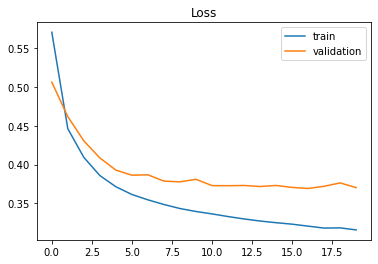

In [244]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Overall accuracy of the prediction from the above model is 85%. However recall for the positive class is only 46% which means it is not able to predict the churners well.

Second model with more layers

In [256]:
model = Sequential()

model.add(Dense(256, activation='relu',kernel_initializer='he_uniform',input_shape=(12,))) ###Multiple Dense units with Relu activation
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

model.add(Dense(num_classes, activation='softmax'))

In [257]:
adam = optimizers.Adam(lr=1e-3)
model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

In [258]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 256)               3328      
                                                                 
 dense_54 (Dense)            (None, 128)               32896     
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dense_56 (Dense)            (None, 32)                2080      
                                                                 
 dense_57 (Dense)            (None, 2)                 66        
                                                                 
Total params: 46,626
Trainable params: 46,626
Non-trainable params: 0
_________________________________________________________________


In [259]:
history=model.fit(X_train, y_train_cat, validation_split=0.2, epochs=50, batch_size=128, verbose=2)

Epoch 1/50
44/44 - 1s - loss: 0.4213 - accuracy: 0.8218 - val_loss: 0.3978 - val_accuracy: 0.8321 - 1s/epoch - 25ms/step
Epoch 2/50
44/44 - 0s - loss: 0.3604 - accuracy: 0.8464 - val_loss: 0.3840 - val_accuracy: 0.8450 - 124ms/epoch - 3ms/step
Epoch 3/50
44/44 - 0s - loss: 0.3312 - accuracy: 0.8580 - val_loss: 0.3963 - val_accuracy: 0.8457 - 123ms/epoch - 3ms/step
Epoch 4/50
44/44 - 0s - loss: 0.3276 - accuracy: 0.8661 - val_loss: 0.3773 - val_accuracy: 0.8500 - 119ms/epoch - 3ms/step
Epoch 5/50
44/44 - 0s - loss: 0.3073 - accuracy: 0.8746 - val_loss: 0.3829 - val_accuracy: 0.8443 - 122ms/epoch - 3ms/step
Epoch 6/50
44/44 - 0s - loss: 0.2978 - accuracy: 0.8771 - val_loss: 0.3805 - val_accuracy: 0.8436 - 127ms/epoch - 3ms/step
Epoch 7/50
44/44 - 0s - loss: 0.2883 - accuracy: 0.8821 - val_loss: 0.3793 - val_accuracy: 0.8471 - 128ms/epoch - 3ms/step
Epoch 8/50
44/44 - 0s - loss: 0.2787 - accuracy: 0.8875 - val_loss: 0.3828 - val_accuracy: 0.8464 - 128ms/epoch - 3ms/step
Epoch 9/50
44/44 -

In [260]:
y_pred = model.predict(X_test)
y_pred[0]

94/94 [==============================] - 0s 1ms/step


array([0.9983499 , 0.00165013], dtype=float32)

In [261]:
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

In [262]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2389
           1       0.58      0.50      0.54       611

    accuracy                           0.83      3000
   macro avg       0.73      0.71      0.72      3000
weighted avg       0.82      0.83      0.82      3000



Recall is 50% for positive class. It is better than before but still we are missing half of the churners.

Attempting the ROC curve

0.792774301747165


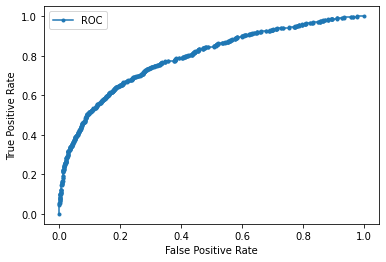

In [263]:
auc = roc_auc_score(y_test,  y_pred[:,1])
print(auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Using the optimal threshold of 0.79 calculated from above

In [265]:
y_pred_final=[]
for i in y_pred:
    if (i[0] > 0.79):
        y_pred_final.append(0)
    else:
        y_pred_final.append(1)

In [266]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      2389
           1       0.51      0.56      0.54       611

    accuracy                           0.80      3000
   macro avg       0.70      0.71      0.71      3000
weighted avg       0.81      0.80      0.81      3000



This improved recall of positive class to 56% but precision of positive class has dropped to 51% which means there are more false positive now.

Third model with dropout and normalization

In [267]:
model = Sequential()

model.add(Dense(256, activation='relu',kernel_initializer='he_uniform',input_shape=(12,))) ###Multiple Dense units with Relu activation
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))

model.add(Dense(num_classes, activation='softmax'))

In [268]:
adam = optimizers.Adam(lr=1e-3)
model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

In [269]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 256)               3328      
                                                                 
 dense_59 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_60 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                     

In [270]:
history=model.fit(X_train, y_train_cat, validation_split=0.2, epochs=100, batch_size=128, verbose=2)

Epoch 1/100
44/44 - 1s - loss: 0.5000 - accuracy: 0.7829 - val_loss: 0.4711 - val_accuracy: 0.8136 - 1s/epoch - 33ms/step
Epoch 2/100
44/44 - 0s - loss: 0.3996 - accuracy: 0.8339 - val_loss: 0.3966 - val_accuracy: 0.8443 - 155ms/epoch - 4ms/step
Epoch 3/100
44/44 - 0s - loss: 0.3797 - accuracy: 0.8411 - val_loss: 0.3790 - val_accuracy: 0.8464 - 145ms/epoch - 3ms/step
Epoch 4/100
44/44 - 0s - loss: 0.3691 - accuracy: 0.8454 - val_loss: 0.3685 - val_accuracy: 0.8536 - 144ms/epoch - 3ms/step
Epoch 5/100
44/44 - 0s - loss: 0.3549 - accuracy: 0.8512 - val_loss: 0.3666 - val_accuracy: 0.8514 - 142ms/epoch - 3ms/step
Epoch 6/100
44/44 - 0s - loss: 0.3525 - accuracy: 0.8530 - val_loss: 0.3766 - val_accuracy: 0.8571 - 141ms/epoch - 3ms/step
Epoch 7/100
44/44 - 0s - loss: 0.3399 - accuracy: 0.8600 - val_loss: 0.3723 - val_accuracy: 0.8521 - 140ms/epoch - 3ms/step
Epoch 8/100
44/44 - 0s - loss: 0.3335 - accuracy: 0.8627 - val_loss: 0.3676 - val_accuracy: 0.8564 - 142ms/epoch - 3ms/step
Epoch 9/10

In [271]:
y_pred=model.predict(X_test)
y_pred[0]

94/94 [==============================] - 0s 1ms/step


array([9.9987268e-01, 1.2735161e-04], dtype=float32)

In [272]:
y_pred_final=[]
for i in y_pred:
  y_pred_final.append(np.argmax(i))

In [273]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2389
           1       0.59      0.51      0.55       611

    accuracy                           0.83      3000
   macro avg       0.73      0.71      0.72      3000
weighted avg       0.82      0.83      0.82      3000



Recall is 51% for the positive class

ROC curve

0.7933114061379248


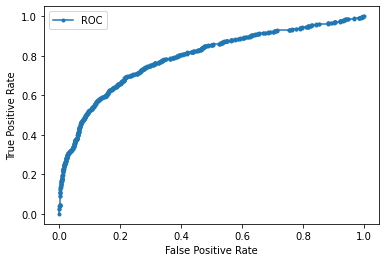

In [274]:
auc = roc_auc_score(y_test,  y_pred[:,1])
print(auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr, marker='.', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [275]:
y_pred_final=[]
for i in y_pred:
    if (i[0] > 0.79):
        y_pred_final.append(0)
    else:
        y_pred_final.append(1)

In [276]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2389
           1       0.53      0.58      0.55       611

    accuracy                           0.81      3000
   macro avg       0.71      0.72      0.72      3000
weighted avg       0.82      0.81      0.81      3000



Recall increased to 58% for the positive class

### Conclusions

* Three neural network models were developed. First a two hidden layer model with 64 and 32 nodes, second a four layer hidden model with 256, 128, 64 and 32 nodes, and a third with four hidden layers of 256, 128, 64 and 32 with a 30% dropout after second layer and batch normalization after third layer.
* Adam optimizer was used for all the models with initial learning rate of 1e-3. Relu was used as the activation for the hidden layers and softmax for the output layer.
* The overall accuracy of all models was in the 80s percentage.
* The first model was run for 20 epochs. The recall for positive class was 46%.
* The second model was run for 50 epochs. It's recall was 50% after roc-auc optimization it increased to 56%.
* The third model was run for 100 epochs. It's recall was 51% and after roc-auc optimization it increased to 58%.
* Overall the recall should be improved further. This could be done by exploring addition of more layers and denser networks. Since the data is imbalanced, techniques like SMOTE can be used to generate more synthetic data for the positive class. This would help increase the recall.